In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [99]:
curr_dir=os.getcwd()
#print(curr_dir)
f_path = os.path.join(curr_dir, "data", "cancer patient data sets.csv")
df=pd.read_csv(f_path)
df=df.drop("index", axis=1)
df.head()

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,P1,33,1,2,4,5,4,3,2,2,...,3,4,2,2,3,1,2,3,4,Low
1,P10,17,1,3,1,5,3,4,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,P100,35,1,4,5,6,5,5,4,6,...,8,7,9,2,1,4,6,7,2,High
3,P1000,37,1,7,7,7,7,6,7,7,...,4,2,3,1,4,5,6,7,5,High
4,P101,46,1,6,8,7,7,7,6,7,...,3,2,4,1,4,2,4,2,3,High


In [100]:
final_features_method2b = ['Age',
 'Alcohol use',
 'Smoking',
 'chronic Lung Disease',
 'Fatigue',
 'Coughing of Blood',
 'Chest Pain',
 'Genetic Risk',
 'OccuPational Hazards',
 'Shortness of Breath',
 'Weight Loss',
 'Clubbing of Finger Nails',
 'Dry Cough',
 'Wheezing']

len(final_features_method2b)

14

In [101]:
from sklearn.model_selection import train_test_split
y = df["Level"]
X = df.drop(["Patient Id","Level"], axis=1)
X= X[final_features_method2b]
y = df["Level"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [102]:
X_train.shape

(700, 14)

# Section 4. Simple Models


In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix


## Simple Models selected for classifcation task
For our multiclass classification task, we first chose two simple models to explore different aspects of predictive performance:

### Model 2. Logistic Regression: 
Logistic Regression is a linear classifier that models the relationship between features and predicts the probability of an instance belonging to a particular class using the sigmoid function. This method allows us to assess performance against our base model which is a linear classifier and validate our base model's ability to effectively separate data points linearly.

*Parameters:*
- C (Regularization Parameter): This parameter controls the inverse of regularization strength. A larger "C" will lead to a weaker regularisation, generating a more complex model, vice-versa.
- solver: Algorithm to use in the optimization problem. 
- penalty: This parameter specifies the norm used in the penalization term. The two most common choices are:
    - L1 Penalty which encourages sparsity by reducing the number of non-zero coefficients
    - L2 Penalty which shrinks coefficients towards zero to prevent overfitting. 
- However, due to compatability issue between L1 penalty and some solvers, we stick with the default settings for both parameters.


### Define functions 

- **gridsearch_method** undergoes a few steps:
    - utilise scikit-learn's GridSearchCV to exhaustively search various hyperparameter combinations provided, aiming to find the most optimal settings for our model. It divides the data into k subsets (defaulting to k=5). During this process, the 'fit' method of GridSearchCV concurrently trains the Classifier on k-1 subsets of the training data ('X_train' and 'y_train'), iteratively testing different hyperparameter configurations with the remaining subset for each fold. 
    - Retrieve Best Estimator: After fitting, the **'best_estimator_'** and its respective **'best_score_'** attribute of the clf object provides the best estimator based on the accuracy found by the GridSearchCV after performing the grid search over the specified hyperparameter space.
    - Retrieve the predicted labels on the test dataset from the model with the best parameters and print out the accuracy score.

In [104]:
def gridsearch_method(model, params, model_name, cv_=5):
    global X_train, X_test, y_train, y_test
    grid=GridSearchCV(model, param_grid=params, cv=cv_)
    grid.fit(X_train, y_train)
    print(f'Best {model_name} hyperparameters: {grid.best_estimator_}')
    print(f'Best {model_name} validation score: {grid.best_score_}')
    y_pred=grid.predict(X_test)
    accuracy_=accuracy_score(y_test, y_pred)
    print(f'{model_name} accuracy on test set: {accuracy_}')
    return grid, y_pred

In [105]:
def evaluation_metrics(y_true, y_pred, model_name, average_type=None): #choices for average_type: {‘binary’, ‘micro’, ‘macro’}
    scores=precision_recall_fscore_support(y_true, y_pred, average=average_type)
    print(f" Precision: {scores[0]:.2f}, Recall: {scores[1]:.2f}, F1-score: {scores[2]:.2f}")
    confusion_scores_matrix = confusion_matrix(y_true, y_pred)
    unique_labels = ["Low", "Medium", "High"]
    sorted_label_ind=[sorted(unique_labels).index(x) for x in unique_labels]
    confusion_scores_matrix_sorted = confusion_scores_matrix[:, sorted_label_ind][sorted_label_ind, :]
    plt.figure(figsize=(10, 6))
    # unique_labels = np.unique(np.concatenate((y_true, y_pred)))
    sns.heatmap(
        
        confusion_scores_matrix_sorted, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
        xticklabels=["Low", "Medium","High"],
        yticklabels=["Low", "Medium","High"]
    )
    
    # ax.set_title(f'Confusion Matrix for {model_name}', fontsize=16, fontweight='bold')
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=14, fontweight='bold')
    plt.yticks(rotation=360)
    plt.show()

In [106]:
logreg_params = {'C': [0.1, 1, 10], 'penalty': ['l2'],'max_iter': [1500]}
logreg, y_pred_logreg=gridsearch_method(model=LogisticRegression(), params= logreg_params, model_name="Logistic Regression")


Best Logistic Regression hyperparameters: LogisticRegression(C=1, max_iter=1500)
Best Logistic Regression validation score: 0.9985714285714286
Logistic Regression accuracy on test set: 1.0


### Manual exploration for hyperparameters in Logistic Regression
Given the single main hyperparameter, "C," inherent in Logistic Regression, we visualised its impact on accuracy. We executed the Logistic Regression model across a range of C values, spanning from 0.001 to 100.


### Define functions

- **explore_logistic_regression** is specifically designed for Logistic Regression, allowing for comparison across different Logistic Regression models with varying feature engineering or modifications if necessary. By plotting accuracy performance against different C values, it offers insights into parameter effects and the bias-variance trade-off.

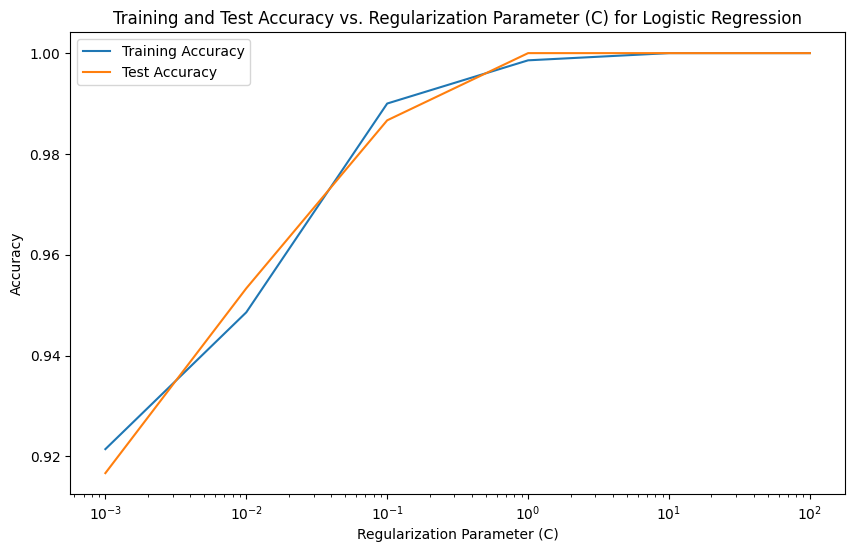

In [107]:
def explore_logistic_regression(C_values):
    global X_train, X_test, y_train, y_test
    train_lst = []
    test_lst = []
    
    for C_value in C_values:
        # Create and fit the logistic regression model
        logreg = LogisticRegression(C=C_value, max_iter=1000)
        logreg.fit(X_train, y_train)
        
        # Compute training error
        train_preds = logreg.predict(X_train)
        train_acc_score= accuracy_score(y_train, train_preds)
        train_lst.append(train_acc_score)
        
        # Compute test error
        test_preds = logreg.predict(X_test)
        test_acc_score= accuracy_score(y_test, test_preds)
        test_lst.append(test_acc_score)
    
    # Plot errors
    plt.figure(figsize=(10, 6))
    plt.plot(C_values, train_lst, label="Training Accuracy")
    plt.plot(C_values, test_lst, label="Test Accuracy")
    plt.xscale('log')  #log scale for C values
    plt.ylabel("Accuracy")
    plt.xlabel("Regularization Parameter (C)")
    plt.title("Training and Test Accuracy vs. Regularization Parameter (C) for Logistic Regression")
    plt.legend()
    plt.show()

# Example usage:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
explore_logistic_regression(C_values)
 

*Figure 17. Graph of Training and Test Accuracy agaisnt a range of Regularization Parameter (C) from 0.001 to 100 in the Logistic Regression model employed.*

As "C" increases from 0.001 to 100 (Figure 17), both training and test accuracy improve. This suggest that when employing a strong regularisation (smaller "C" value), the model will become simpler, exhibiting underfitting, particularly when excessively low "C" values is used. This could be due to the high bias observed. <br>

Notably, the model maintain relatively high accuracy overall across the "C" values but peaks between 10 and 100 in "C" (Figure 17). The higher spectrum of the "C" values in the graph suggest that weak regularisation in the linear model yields the optimal performance in predicting the classification of our dataset. However, we opted for optimal value of 10, as it is closer to the default value (C=1), aiming to prevent excessively high variance and enhance generalisation performance.

### Evalutation of Model 2

 Precision: 1.00, Recall: 1.00, F1-score: 1.00


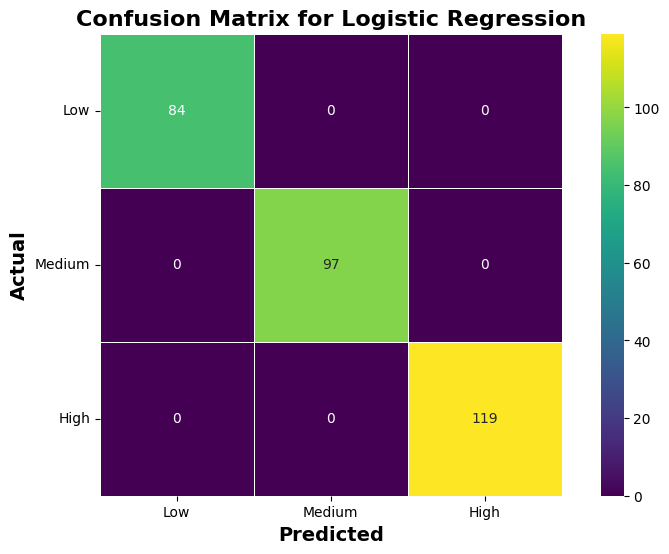

In [108]:
evaluation_metrics(y_test, y_pred_logreg, 'Logistic Regression', average_type='macro')

*Figure 18. The confusion matrix for Logistic Regression. The heatmap illustrates classification results with "Low," "Medium," and "High" labels, while side labels show counts for each prediction.*

Similar to the baseline model, the Logistic Regression model achieves perfect classification accuracy on the test set, as evidenced by a lack of misclassifications observed in the confusion matrix (Figure 18). Consequently, precision, recall, and F1-score all attain a value of 1. This validates the suitability of using linear models for predicting lung cancer occurrence in the dataset.

Furthermore, the feature engineering applied to the dataset highlight the effectiveness of the chosen features in capturing relevant information for the classification task.

### Model 3: k-nearest neighbors (KNN)
KNN model is a simple yet expressive method that allows us to handle complex decision boundaries as it adeptly captures local data structure by considering the nearest neighbors. This making it a valuable addition to our analysis.
*Parameters:*
- n_neighbours: Determines the number of nearest neighbors to consider when making predictions. Adjusting this parameter impacts the model's flexibility.
- p: The power parameter for the Minkowski distance metric.When p=1, it is equivalent to using Manhattan distance (L1), and when p=2, it is equivalent to using Euclidean distance (L2). This have an impact on the distance calcualtion and could possibly affect the results.

In [109]:
knn_params = {'n_neighbors': [3, 5, 7, 9], 'p': [1, 2, 3]}
knn_, y_pred_knn=gridsearch_method(model=KNeighborsClassifier(), params= knn_params, model_name="KNN")

Best KNN hyperparameters: KNeighborsClassifier(n_neighbors=3, p=1)
Best KNN validation score: 0.9985714285714286
KNN accuracy on test set: 0.9966666666666667


### Manual exploration for hyperparameters in KNN
Similarly, KNN has one main parameter, "n_neighbours", representing the number of nearest neighbors. Here, we ran the KNN model across a range of k_neighbours values, spanning from 1 to 20.

### Define functions
- **explore_kNN** is specifically designed for KNN, allowing for comparison across different KNN models with varying feature engineering or modifications if necessary. By plotting accuracy performance against different k_neighbours values, it offers insights into parameter effects and the bias-variance trade-off.

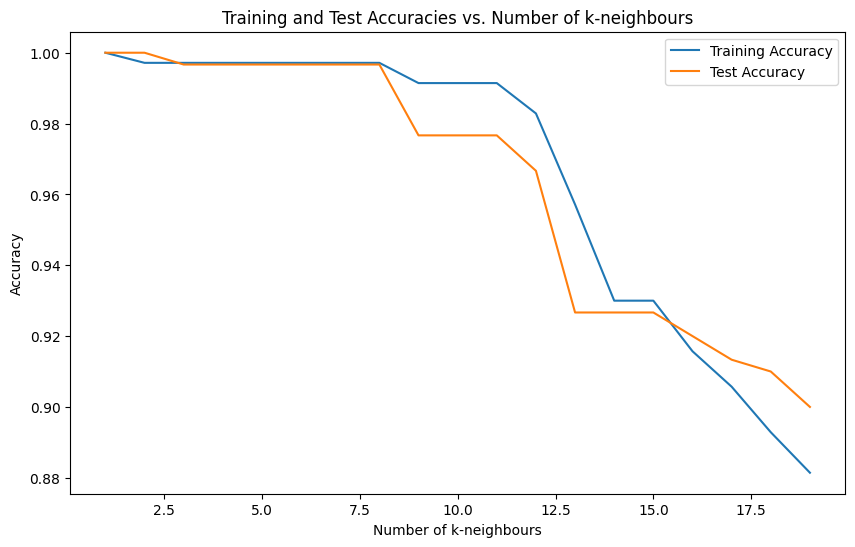

In [110]:
# Define the range of neighbors
k_neighbours_lst = range(1, 20)

def explore_kNN(k_neighbours_lst):
    global X_train, X_test, y_train, y_test
    train_lst=[]
    test_lst=[]


    for neighbour in k_neighbours_lst:
        knn = KNeighborsClassifier(n_neighbors=neighbour)
        knn.fit(X_train, y_train)
        train_preds=knn.predict(X_train)
        train_acc_score= accuracy_score(y_train, train_preds)
        train_lst.append(train_acc_score)
        test_preds=knn.predict(X_test)
        test_acc_score= accuracy_score(y_test, test_preds)
        test_lst.append(test_acc_score)

    # print(k_neighbours_lst, train_lst)
    # print(k_neighbours_lst, test_lst)
    plt.figure(figsize=(10, 6))
    plt.plot(k_neighbours_lst, train_lst, label="Training Accuracy")
    plt.plot(k_neighbours_lst, test_lst, label="Test Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of k-neighbours")
    plt.title("Training and Test Accuracies vs. Number of k-neighbours")
    plt.legend()
    plt.show()


explore_kNN(k_neighbours_lst)

*Figure 19. Graph of Training and Test Accuracy agaisnt a range of k from 1 to 20 in the kNN model employed.*

Across the range of k values from 1 to 12 (Figure 19), both test and training accuracies consistently remain high. This indicates that the model's ability to achieves perfect to almost-prefect accuracy on the test data when using these selected features and the range of hyperparameters. This suggests that the model's performance on unseen data (test set) is generally excellent. However, for optimal performance, we chose value of k=3 onwards as very small k of k=1 to 2 can lead to excessively high variance and overfitting for future dataset. 

However, in Figure 19, beyond k=12, there is notable drop in test accuracy drop. This occurs because the larger "k" values results in the decision boundary to be too smooth, overlooking important patterns in the data, which leads to high bias and underfitting.

### Evalutation of Model 3

 Precision: 1.00, Recall: 1.00, F1-score: 1.00


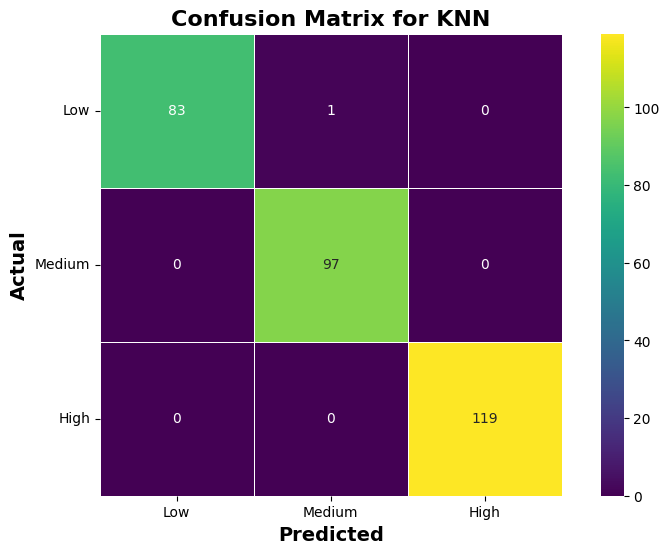

In [111]:
evaluation_metrics(y_test, y_pred_knn, 'KNN', average_type='macro')


*Figure 20. The confusion matrix for KNN. The heatmap illustrates classification results with "Low," "Medium," and "High" labels, while side labels show counts for each prediction.*

Although Figure 20 exhibit KNN having 1 label being misclassified, resulting in the F1 score for the "Low" class to be 0.994, the macro-average of the F1-score is 0.998, which round to 1.000 when formatting to 3dp. This highlights the robust performance of the KNN model in accurately predicting lung cancer occurrence across the dataset.

To conclude,  both models (logistic regression and KNN) exhibit excellent performance on the given dataset, even when using a subset of features selected based on pca, achieve almost-perfect accuracy on both training and test datasets for certain values of hyperparameters. These results suggest that the models are able to effectively capture the underlying patterns in the data and also validate that it generalise well to unseen data.

# Section 5. Ensemble Learning Methods

In [112]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Ensemble Learning Methods
We might lean towards Ensemble Learning Methods for biological data because we recognize that biological systems can be non-parametric and complex. Ensemble methods are better equipped to handle these intricate relationships between features. As datasets grow and more factors are discovered, these ensemble methods remain adaptable and effective, making them more applicable in the long term, especially in the context of studying conditions like lung cancer.

### Model 4. Random Forest Classifier
Random Forest Classifier is an ensemble learning technique that builds numerous decision trees during training and uses the most common class prediction among the trees for classification tasks. By aggregating predictions from multiple trees, it improves accuracy and resilience in making predictions.

*RF Algorithm:*

- Bootstrap Sampling: Random Forest builds multiple decision trees by sampling, with replacement, from the training dataset (bootstrap sampling).
- Feature Randomization: At each node of the tree, a random subset of features is considered for splitting, adding diversity to the trees.
- Voting Mechanism: For classification, the mode (most frequent class) among the trees is the final predicted class.
- Ensemble Learning: Random Forest is an ensemble learning method that combines the predictions of multiple decision trees to improve predictive performance and robustness. 

*Parameters:*

- n_estimators: Number of trees in the forest. Higher values generally lead to better performance.
- criterion: The function to measure the quality of a split. 'gini' for Gini impurity or 'entropy' for information gain.
- max_depth: Maximum depth of the individual trees. Controls the complexity of each tree.
- min_samples_split: Minimum number of samples required to split an internal node.
- min_samples_leaf: Minimum number of samples required to be at a leaf node.
- class_weight: Weights associated with classes in the form {class_label: weight}.

In [113]:
rf_params = {'max_depth':[2,10,50],
             'n_estimators':[1,10,100,500,1000]}

rdf = RandomForestClassifier(random_state=0)

In [114]:
rf_model, y_pred_rf = gridsearch_method(rdf, params=rf_params, model_name="Random Forest")

Best Random Forest hyperparameters: RandomForestClassifier(max_depth=10, n_estimators=1, random_state=0)
Best Random Forest validation score: 1.0
Random Forest accuracy on test set: 1.0


In [115]:
rf_model.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=1, random_state=0)

### Manual exploration for hyperparameters in Random Forest
Using cross-validation, we visualize the analysis of different hyperparameter configurations for a Random Forest model by organizing and presenting the results in a tabular format, making it easier to identify the most effective parameter settings.

In [116]:
results_df = pd.DataFrame(rf_model.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
10_1,"{'max_depth': 10, 'n_estimators': 1}",1,1.000000,0.000000
10_10,"{'max_depth': 10, 'n_estimators': 10}",1,1.000000,0.000000
10_100,"{'max_depth': 10, 'n_estimators': 100}",1,1.000000,0.000000
10_500,"{'max_depth': 10, 'n_estimators': 500}",1,1.000000,0.000000
10_1000,"{'max_depth': 10, 'n_estimators': 1000}",1,1.000000,0.000000
50_1,"{'max_depth': 50, 'n_estimators': 1}",1,1.000000,0.000000
50_10,"{'max_depth': 50, 'n_estimators': 10}",1,1.000000,0.000000
50_100,"{'max_depth': 50, 'n_estimators': 100}",1,1.000000,0.000000
50_500,"{'max_depth': 50, 'n_estimators': 500}",1,1.000000,0.000000


In [117]:
model_scores = results_df.filter(regex=r"split\d*_test_score")

_Table X: Result table of an exhaustive exploration of hyperparameter combinations for a Random Forest model._ 

Notably, configurations with a max depth of 10 or 50, paired with various numbers of estimators, consistently achieved the top rank with perfect test scores and minimal variance. This suggests that these depth values effectively capture the complexity of the dataset, while increasing the number of estimators beyond a certain threshold doesn't significantly enhance performance. <br>

Conversely, configurations with a max depth of 2 generally performed less optimally, indicating the importance of sufficient depth for capturing underlying patterns in the data. Despite variations in hyperparameters, the Random Forest model demonstrates robustness, consistently achieving high test scores across different configurations. 

These findings underscore the importance of carefully tuning hyperparameters to optimize model performance, with an emphasis on balancing depth and the number of estimators in Random Forest models for effective predictive accuracy.

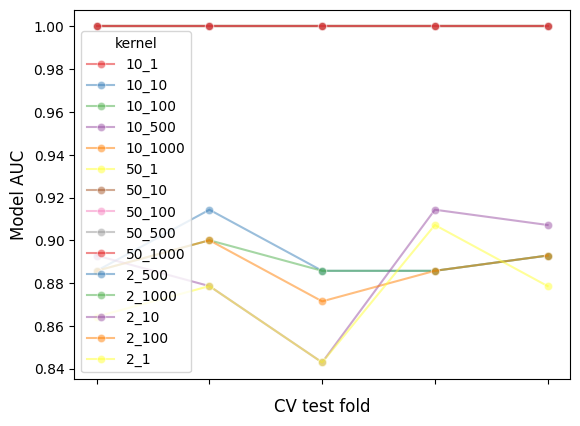

In [118]:
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

_Figure 21: Line plot visualizing the cross-validation (CV) test fold results for multiple models._

Each line represents the area under the receiver operating characteristic curve (AUC) across different folds. The x-axis represents the CV test fold, while the y-axis indicates the model AUC. The use of markers, palette, and transparency enhances readability and distinguishes between multiple lines corresponding to different models. By displaying AUC values across CV folds, the plot offers insights into the consistency and variability of model performance. A consistent upward trend or plateau across folds suggests stable and robust performance, while erratic fluctuations may indicate instability or sensitivity to specific data subsets.

### Evalutation of Model 5

In [119]:
# Displaying the importance of each feature
optimised_rf_model = RandomForestClassifier(max_depth=10, n_estimators=1, random_state=0)
optimised_rf_model.fit(X_train, y_train)
feature_importance = pd.DataFrame(optimised_rf_model.feature_importances_, index=X_train.columns, columns=['importance'])
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)

                          importance
OccuPational Hazards        0.282171
Fatigue                     0.211447
Dry Cough                   0.147631
Smoking                     0.140221
chronic Lung Disease        0.059554
Genetic Risk                0.050361
Alcohol use                 0.037524
Weight Loss                 0.027913
Chest Pain                  0.017764
Wheezing                    0.012885
Shortness of Breath         0.012527
Age                         0.000000
Coughing of Blood           0.000000
Clubbing of Finger Nails    0.000000




Random Forest has a tendency to distribute feature importance more evenly compared to some other models, especially when features are highly correlated with the target variable. This behavior stems from the nature of how Random Forest calculates feature importance. In a Random Forest model, feature importance is typically determined by measuring the decrease in impurity (e.g., Gini impurity) when a particular feature is used for splitting nodes in the trees of the forest.

When features are highly correlated with the target variable, they tend to be selected more frequently for splitting nodes across different trees in the forest, leading to a more equitable distribution of importance among correlated features. This can result in a situation where multiple features contribute significantly to the predictive power of the model, rather than one or a few features dominating the importance ranking. As a result, Random Forest models often provide a more nuanced understanding of feature importance, particularly in scenarios where multiple features are informative predictors of the target variable.

 Precision: 1.00, Recall: 1.00, F1-score: 1.00


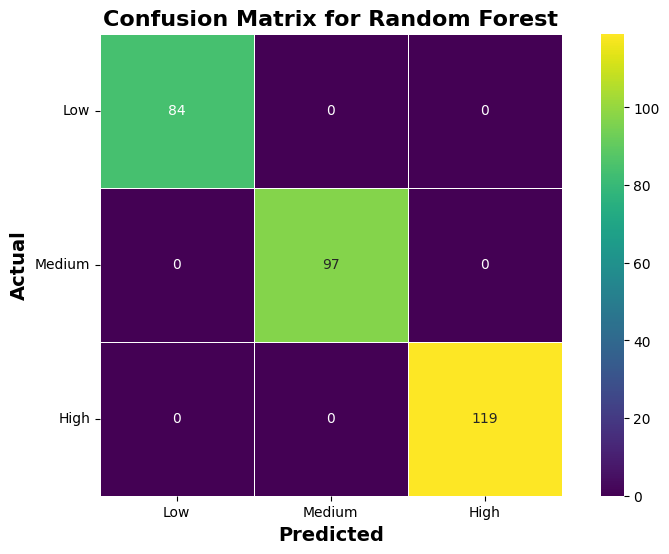

In [120]:
evaluation_metrics(y_test, y_pred_rf, 'Random Forest', average_type='macro')

_Figure 22. The confusion matrix for Random Forest. The heatmap displays the classification results with "Low," "Medium," and "High" labels, while the side labels indicate the counts for each prediction._

Precision, recall, and F1-score are all 1.00, indicating perfect performance for the "High" class. There are 119 instances of this class. Similarly, perfect scores are achieved for precision, recall, and F1-score for the "Low" class. There are 84 instances of this class. Again, perfect scores for precision, recall, and F1-score for the "Medium" class, with 97 instances.

Overall accuracy of the model is also reported as 1.00, indicating perfect accuracy across all classes.

### Model 5. Gradient Boosting Decision Tree (GBDT)

GBDT is an ensemble learning method used for both classification and regression tasks. They work by combining multiple weak learners, typically decision trees, to create a strong predictive model. <br>

*GBDT Algorithm:*
- Decision Trees as Weak Learners: The base learners (weak learners) in a GBDT model are usually decision trees. 
- Gradient Boosting: Fitting the new tree to the residuals (the differences between the actual and predicted values) of the previous tree.
- Gradient Descent Optimization: Iteratively fits a new tree to the negative gradient of the loss function with respect to the predicted values. 
- Shrinkage (Learning Rate): Control the contribution of each tree to the ensemble

*Parameters:*
- n_estimators: Number of trees in the ensemble
- learning_rate: Shrinkage parameter
- max_depth: Maximum depth of the individual trees
- min_samples_split: Minimum number of samples required to split an internal node
- min_samples_leaf: Minimum number of samples required to be at a leaf node
- subsample: Fraction of samples to be used for fitting the individual trees

### Hyperparameter tuning of Gradient Boosting Classifier

To train a Gradient Boosting Classifier with optimal hyperparameters using scikit-learn's GridSearchCV, we start by defining a parameter grid containing various hyperparameter values to search over. These hyperparameters include the number of boosting stages (**n_estimators**), the learning rate (**learning_rate**), the maximum depth of the individual regression estimators (**max_depth**), the minimum number of samples required to split an internal node (**min_samples_split**), the minimum number of samples required to be at a leaf node (**min_samples_leaf**), and the fraction of samples used for fitting the individual base learners (**subsample**).


In [129]:
# Define the parameter grid to search
gbdt_params = {
    'n_estimators': [50, 100], 
    'learning_rate': [0.05, 0.1],  
    'max_depth': [3, 5],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'subsample': [0.8, 0.9, 1.0]  
}

# Initialize the GBDT model
gbdt_= GradientBoostingClassifier(random_state=42)

In [122]:
gbdt_model, y_pred_gbdt = gridsearch_method(gbdt_, params=gbdt_params, model_name="Gradient Boosting", cv_=3)

Best Gradient Boosting hyperparameters: GradientBoostingClassifier(learning_rate=0.05, n_estimators=50, random_state=42,
                           subsample=0.8)
Best Gradient Boosting validation score: 1.0
Gradient Boosting accuracy on test set: 1.0


In [123]:
gbdt_model.best_estimator_

GradientBoostingClassifier(learning_rate=0.05, n_estimators=50, random_state=42,
                           subsample=0.8)

After fitting the grid search object to the training data (**'X_train'** and **'y_train'**), we retrieve the best estimator found by accessing the **'best_estimator_'** attribute of the **'grid_search'** object. This **'best_gb_estimator'** instance represents the Gradient Boosting Classifier with the optimal hyperparameters identified through the grid search.

The GBDT model with hyperparameter tuning also predicts "Low", "Medium" and "High" Levels of Lung Cancer in patients with an Accuracy of 1.0. <br>
Accuracy is the ratio of correctly predicted instances to the total number of instances in the dataset. It measures the overall correctness of the model's predictions across all classes.

### Manual exploration for hyperparameters in Gradient Boosting Classifier
Given the multitude of hyperparameters involved for this model, one of the primary ones is the learning rate, which directly influences the number of trees in the model. This, in turn, impacts how effectively the model fits the data. Hence, we visualise the learning curve of the model.

Note that optimised_gbdt_model is used instead of gbdt_model earlier on as running the same method as gbdt_model takes a lot of computation time

In [124]:
optimised_gbdt_model = GradientBoostingClassifier(learning_rate=0.05, 
                                           max_depth=3, 
                                           min_samples_leaf=1, 
                                           min_samples_split=2, 
                                           n_estimators=50, 
                                           subsample=0.8,
                                           random_state=42)

optimised_gbdt_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=50, random_state=42,
                           subsample=0.8)

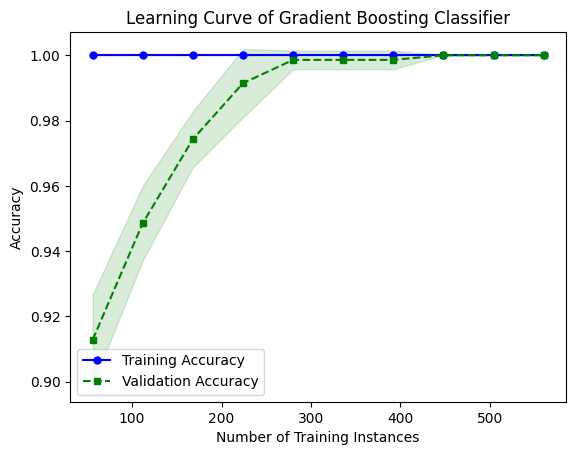

In [125]:
train_sizes, train_scores, test_scores = learning_curve(optimised_gbdt_model, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.xlabel('Number of Training Instances')
plt.ylabel('Accuracy')
plt.title('Learning Curve of Gradient Boosting Classifier')
plt.legend()
plt.show()


_Figure 23. Learning curve of the Gradient Boosting Classifier using cross-validation and plot the training and validation accuracy as a function of the number of training instances._

The training accuracy is consistently high at 1.0, indicating that the model is able to capture the complexities of the training data well. However, we also abserve that the validation accuracy reaches a high value of 1.0 relatively quickly, at around 450 Training Instances, which suggests that the model generalizes well to unseen data.

This situation could indeed indicate that the model is not overfitting, despite achieving high training accuracy. Overfitting occurs when the model learns to capture noise in the training data rather than the underlying patterns, leading to poor generalization to new data. However, if both training and validation accuracies are high and converge quickly, it suggests that the model is not merely memorizing the training data but is instead capturing meaningful patterns that generalize to unseen data.

In [126]:
# Cross-validation
cv_scores = cross_val_score(optimised_gbdt_model, X, y, cv=5, scoring='accuracy')
print(f'CV Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

CV Accuracy Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0


The accuracy scores obtained for each fold of the cross-validation process is 1.0, it suggests that the model achieved perfect accuracy on each fold of the cross-validation. A perfect accuracy score of 1.0 means that the model correctly classified all instances in the validation set for that fold.

In [127]:
# Displaying the importance of each feature
feature_importance = pd.DataFrame(optimised_gbdt_model.feature_importances_, index=X_train.columns, columns=['importance'])
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)

                          importance
Coughing of Blood           0.283937
Fatigue                     0.159860
Alcohol use                 0.150337
Wheezing                    0.142297
Smoking                     0.106935
Age                         0.038771
Clubbing of Finger Nails    0.036707
OccuPational Hazards        0.033646
Chest Pain                  0.021267
chronic Lung Disease        0.011048
Dry Cough                   0.008059
Weight Loss                 0.002670
Shortness of Breath         0.002525
Genetic Risk                0.001941


GBDT typically assigns higher importance to features that are more effective at reducing the model's loss function during the boosting process. GBDT tends to concentrate importance on a subset of features that are particularly informative or predictive. This concentration occurs because the model sequentially builds a series of weak learners (usually decision trees) where each subsequent learner focuses on minimizing the residual errors made by the previous learners. 

Consequently, features that are more effective at reducing these errors receive higher importance weights, leading to a more concentrated feature importance distribution. As a result, GBC often identifies a smaller set of key features that have the most significant impact on model performance, providing insights into the most influential predictors in the dataset. This concentrated feature importance can be advantageous for interpretability and understanding the underlying mechanisms driving predictions.

 Precision: 1.00, Recall: 1.00, F1-score: 1.00


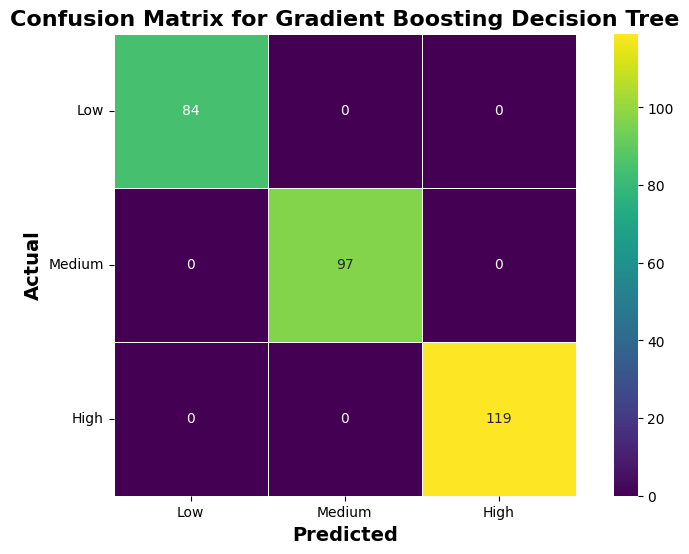

In [128]:
evaluation_metrics(y_test, y_pred_gbdt, 'Gradient Boosting Decision Tree', average_type='macro')

_Figure 24. The confusion matrix for Gradient Boosting Decision Tree. The heatmap displays the classification results with "Low," "Medium," and "High" labels, while the side labels indicate the counts for each prediction._

Similar to the the Logistic Regression and Random Forest model achieves flawless classification accuracy on the test set, as evident from the absence of misclassifications depicted in the confusion matrix (Figures 18, 22 and 24). Consequently, precision, recall, and F1-score all reach a value of 1. This reaffirms the effectiveness of employing ensemble methods, such as Random Forest, for predicting lung cancer occurrence in the dataset.